<a href="https://colab.research.google.com/github/Estelle007/Neuro-GAN/blob/master/preprocess_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = "/content/drive/Shareddrives/guoxinyu"
os.chdir(path) # 切换工作目录

Mounted at /content/drive


In [ ]:
! pip install dicom
! pip install pydicom

In [ ]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = './3DCT/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [ ]:
# Load the scans in given folder path
# 扫描一个患者的目录，加载所有的切片，按切片的z方向排序切片，并获取切片厚度
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [ ]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

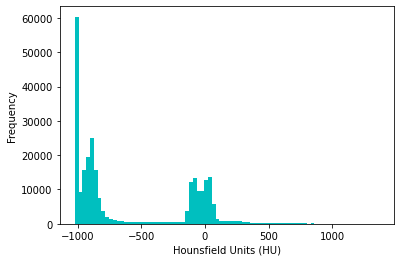

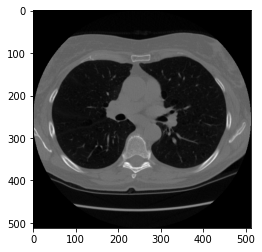

In [ ]:
first_patient = load_scan(INPUT_FOLDER + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels[80].flatten(), bins=80, color='c') #
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

In [ ]:
print(first_patient[80].PatientID)

00cba091fa4ad62cc3200a657aeb957e


In [ ]:
first_patient_pixels[80]

array([[-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       ...,
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024]], dtype=int16)

# Resampling
A scan may have a pixel spacing of [2.5, 0.5, 0.5], which means that the distance between slices is 2.5 millimeters. For a different scan this may be [1.5, 0.725, 0.725], this can be problematic for automatic analysis (e.g. using ConvNets)!

A common method of dealing with this is resampling the full dataset to a certain isotropic resolution. If we choose to resample everything to 1mm1mm1mm pixels we can use 3D convnets without worrying about learning zoom/slice thickness invariance.

Whilst this may seem like a very simple step, it has quite some edge cases due to rounding. Also, it takes quite a while.

Below code worked well for us (and deals with the edge cases):

In [ ]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [ ]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (134, 512, 512)
Shape after resampling	 (335, 306, 306)


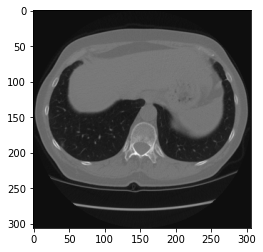

In [ ]:
plt.imshow(pix_resampled[80], cmap=plt.cm.gray)
plt.show()

In [ ]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

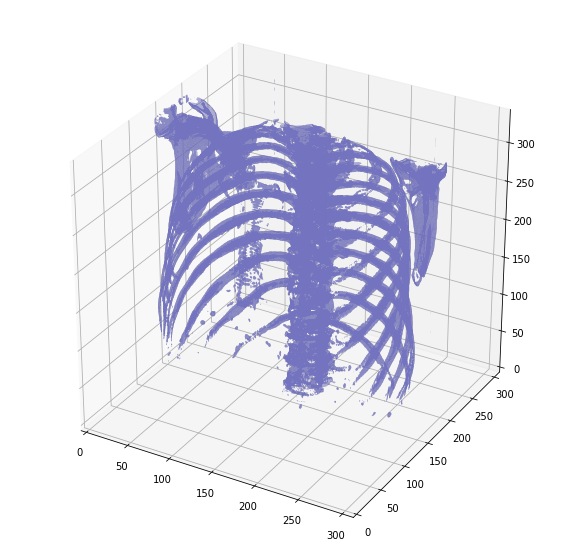

In [ ]:
plot_3d(pix_resampled, 400) # 400 is a good threshold for showing the bones only

# Segmentation of Lungs-method1

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import dicom
import scipy.misc
import numpy as np

def get_segmented_lungs(im, plot=False):
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < -400
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im

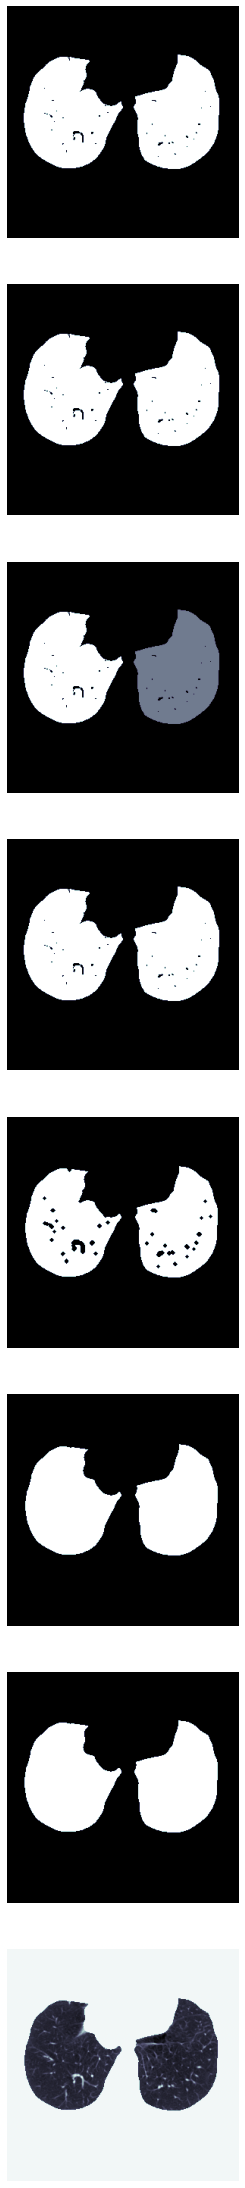

In [ ]:
im = get_segmented_lungs(pix_resampled[101], True)

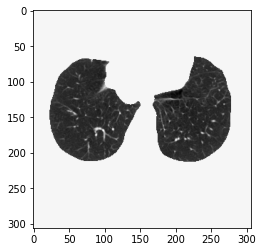

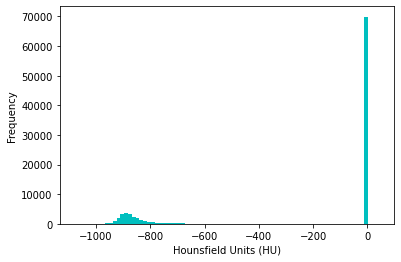

In [ ]:
plt.imshow(im, cmap=plt.cm.gray)
plt.show()
plt.hist(im.flatten(), bins=80, color='c') #
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()


# Segmentation of Lungs-Method2

In [ ]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [ ]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

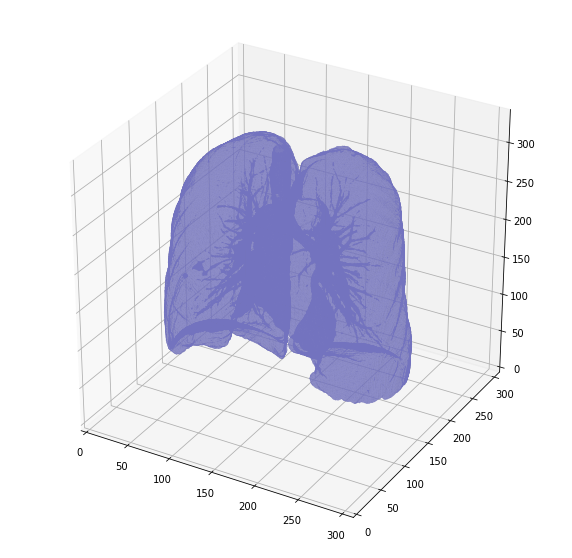

In [ ]:
plot_3d(segmented_lungs, 0)

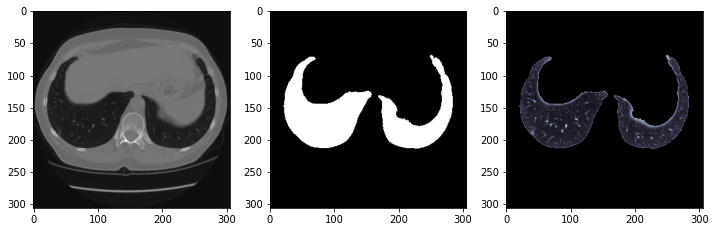

In [ ]:
origin = pix_resampled[80]
plt.figure(figsize=(12, 12))
plt.subplot(131)
plt.imshow(origin, cmap=plt.cm.gray)
image = pix_resampled[80]
binary = segmented_lungs_fill[80]
get_high_vals = binary == 0
image[get_high_vals] = -1024
plt.subplot(132)
plt.imshow(segmented_lungs_fill[80], cmap=plt.cm.gray)
plt.subplot(133)
plt.imshow(image, cmap=plt.cm.bone)
plt.show()


[[-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 ...
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]]


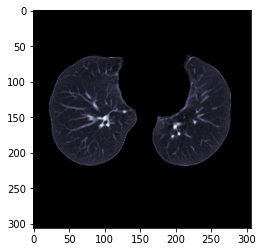

In [ ]:
MAX = len(pix_resampled)
shape = pix_resampled[MAX-1].shape
img = np.ones(shape,dtype=np.uint8)*(-1024)
print(img)
for num in range(130,140):
  image = pix_resampled[num]
  binary = segmented_lungs_fill[num]
  get_high_vals = binary == 0
  image[get_high_vals] = -1024
  img = img + image

lung = img/11
plt.imshow(lung, cmap=plt.cm.bone)
plt.show()


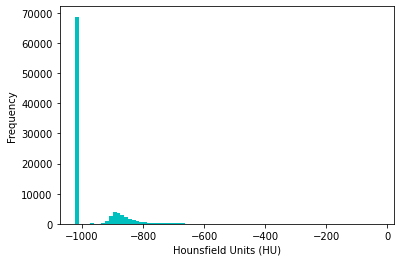

In [ ]:
plt.hist(lung.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Another Approach

In [ ]:
# Standard imports
import numpy as np
import pandas as pd
import os
import glob
import cv2

# Imaging libraries
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns
#p = sns.color_palette()
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

# Pandas configuration
pd.set_option('display.max_columns', None)
print('OK.')
print(cv2.__version__)

OK.
4.1.2


In [ ]:
# get patients list
import dicom
dicom_root = './3DCT/'
patients = [ x for x in os.listdir(dicom_root) if len(x)==32 ]
print('Patient count: {}'.format(len(patients)))

Patient count: 3


In [ ]:
# DICOM rescale correction
def rescale_correction(s):
    s.image = s.pixel_array * s.RescaleSlope + s.RescaleIntercept

# Returns a list of images for that patient_id, in ascending order of Slice Location
# The pre-processed images are stored in ".image" attribute
def load_patient(patient_id):
    files = glob.glob(dicom_root + '/{}/*.dcm'.format(patient_id))
    slices = []
    for f in files:
        dcm = dicom.read_file(f)
        rescale_correction(dcm)
        # TODO: spacing eq.
        slices.append(dcm)
    
    slices = sorted(slices, key=lambda x: x.SliceLocation)
    return slices

00cba091fa4ad62cc3200a657aeb957e


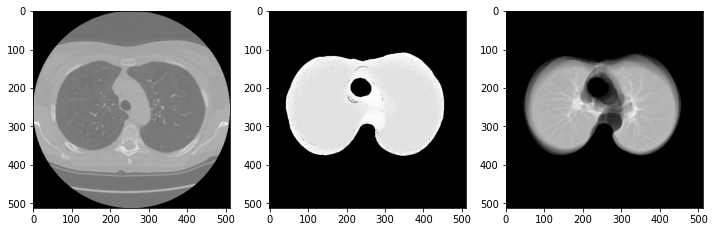

00edff4f51a893d80dae2d42a7f45ad1


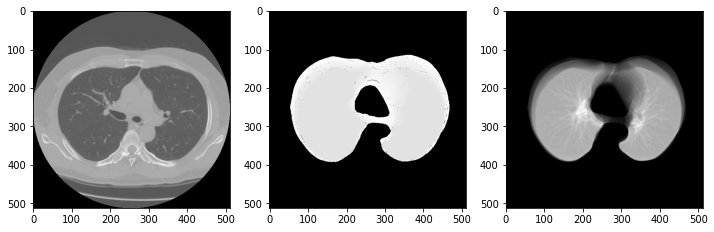

0a0c32c9e08cc2ea76a71649de56be6d


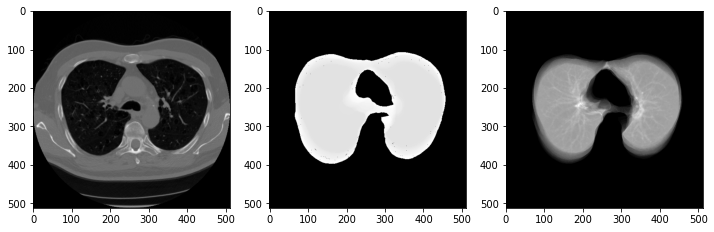

In [ ]:
# Load a patient
for patient_no in patients:
  pat = load_patient(patient_no)
  print(patient_no)
  shape = pat[ 0 ].image.copy().shape 
  img_mask = np.zeros(shape,dtype=np.uint8)
  img_lung = np.zeros(shape,dtype=np.uint8)
  MAX = len(pat)
  for num in range(80,110):
    
    img = pat[ num ].image.copy() 

    # threshold HU > -300
    # convert into binary image
    img[img>-300] = 255
    img[img<-300] = 0
    img = np.uint8(img)

    # find surrounding torso from the threshold and make a mask
    contours, hierarchy = cv2.findContours(img,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros(img.shape, np.uint8)
    cv2.fillPoly(mask, [largest_contour], 255)

    # apply mask to threshold image to remove outside. this is our new mask
    img = ~img
    img[(mask == 0)] = 0 # <-- Larger than threshold value

    # apply closing to the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)  # <- to remove speckles...
    img = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
    
    # apply mask to image
    img2 = pat[ num ].image.copy()
    img2[(img == 0)] = -2000 # <-- Larger than threshold value

    img_mask = img_mask + img
    img_lung = img_lung + img2
    # closing
    #sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    #largest_contour = max(contours, key=cv2.contourArea)
    #rgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    #aaa = np.concatenate( sorted_contours[1:3] )
    #cv2.drawContours(rgb, [cv2.convexHull(aaa)], -1, (0,255,0), 3)
  
  img_mask = img_mask/MAX
  img_lung = img_lung/MAX

  
  plt.figure(figsize=(12, 12))
  plt.subplot(131)
  plt.imshow(pat[ 100 ].image, cmap=plt.cm.gray)
  plt.subplot(132)
  plt.imshow(img_mask, cmap=plt.cm.gray)
  plt.subplot(133)
  plt.imshow(img_lung, cmap=plt.cm.gray)
  plt.show()

In [ ]:
img_lung

array([[-2000., -2000., -2000., ..., -2000., -2000., -2000.],
       [-2000., -2000., -2000., ..., -2000., -2000., -2000.],
       [-2000., -2000., -2000., ..., -2000., -2000., -2000.],
       ...,
       [-2000., -2000., -2000., ..., -2000., -2000., -2000.],
       [-2000., -2000., -2000., ..., -2000., -2000., -2000.],
       [-2000., -2000., -2000., ..., -2000., -2000., -2000.]])